# Basic Calculation

$\mathrm{Cov(X,Y)=E[(X-E[X])(Y-E[X])]}$

In [2]:
import numpy as np

In [20]:
Z = np.array([
    [1, 10],
    [2, 20],
    [4, 40]
])

In [28]:
np.cov(Z, rowvar=False, bias=False)

array([[  2.33333333,  23.33333333],
       [ 23.33333333, 233.33333333]])

In [23]:
Z_X, Z_Y = Z[:,0], Z[:,1]
Z_X_mean, Z_Y_mean = Z_X.mean(), Z_Y.mean()

In [27]:
sum = 0
for i in range(len(Z)):
    Z_x = Z_X[i] - Z_X_mean
    Z_y = Z_Y[i] - Z_Y_mean
    print(f"{Z_x},{Z_y}")
    sum += Z_x * Z_y
print(sum/(len(Z)-1))


-1.3333333333333335,-13.333333333333332
-0.3333333333333335,-3.333333333333332
1.6666666666666665,16.666666666666668
23.333333333333336


In [35]:
np.cov(Z)

array([[ 40.5,  81. , 162. ],
       [ 81. , 162. , 324. ],
       [162. , 324. , 648. ]])

In [38]:
Z_1, Z_2, Z_3 = Z[0], Z[1], Z[2]
print(f"{Z_1}, {Z_2}, {Z_3}")
Z_1_mean, Z_2_mean, Z_3_mean = Z_1.mean(), Z_2.mean(), Z_3.mean()
print(f"{Z_1_mean}, {Z_2_mean}, {Z_3_mean}")

[ 1 10], [ 2 20], [ 4 40]
5.5, 11.0, 22.0


In [41]:
sum = 0
for i in range(len(Z.T)):
    Z_1_i = Z_1[i] - Z_1_mean
    Z_2_i = Z_2[i] - Z_2_mean
    Z_3_i = Z_3[i] - Z_3_mean
    sum += Z_1_i * Z_3_i
print(sum/(len(Z.T)-1))


162.0


# Casual Inference

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=42)

In [2]:
size = 10000 #@param

In [14]:
X1 = rng.normal(loc=0.0, scale=1.0, size = size)
X2 = rng.normal(loc=0.0, scale=1.0, size = size)

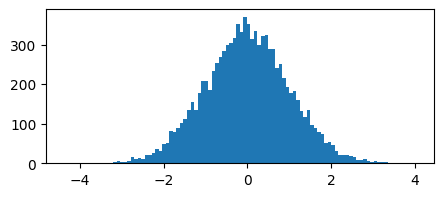

In [13]:
figure = plt.figure(figsize=(5,2))
plt.hist(X1, bins=100)
plt.show()

In [24]:
logits_T = -0.5 + 0.8 * X1 - 0.3 * X2
p_T = 1 / (1 + np.exp(-logits_T))
T_even = rng.binomial(n=1, p=0.5, size=size)
T = rng.binomial(n=1, p=p_T, size=size)

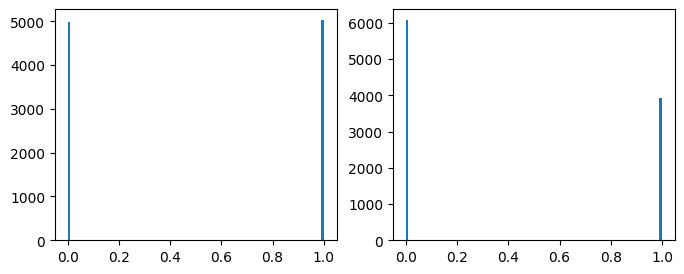

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axes[0].hist(T_even, bins=100)
axes[1].hist(T, bins=100)
plt.show()

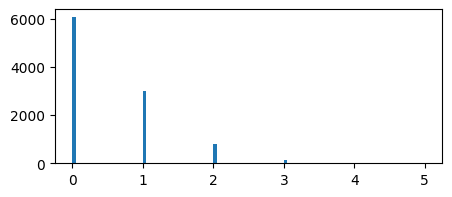

In [30]:
events = rng.poisson(lam=0.5, size=size)
fig = plt.figure(figsize=(5,2))
plt.hist(events, bins=100)
plt.show()

In [31]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(seed=42)

def simulate_causal_data(n=10_000, tau=2.0, noise_std=1.0, seed=None):
    """
    Simulate observational data with:
      - Confounders X1, X2
      - Binary treatment T influenced by X
      - Outcome Y influenced by X and T
    True ATE is approximately 'tau'.
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # 1) Generate covariates (confounders)
    X1 = rng.normal(loc=0.0, scale=1.0, size=n)        # e.g. "baseline risk"
    X2 = rng.normal(loc=0.0, scale=1.0, size=n)        # e.g. "health score"

    # 2) Treatment assignment (observational, *not* randomized)
    #    Treatment probability depends on X1, X2 -> confounding
    logits_T = -0.5 + 0.8 * X1 - 0.3 * X2
    p_T = 1 / (1 + np.exp(-logits_T))                  # sigmoid
    T = rng.binomial(n=1, p=p_T, size=n)

    # 3) Outcome generation
    #    Outcome depends on X1, X2 and treatment T
    #    tau is the true average treatment effect
    baseline = 1.0 + 1.5 * X1 + 0.5 * X2
    Y = baseline + tau * T + rng.normal(0, noise_std, size=n)

    df = pd.DataFrame({
        "X1": X1,
        "X2": X2,
        "T": T,
        "Y": Y
    })

    return df, tau

df, true_ate = simulate_causal_data(n=50_000, tau=3.0, noise_std=1.0, seed=42)
print(df.head())
print("True ATE:", true_ate)


         X1        X2  T         Y
0  0.304717  0.769680  0  2.746264
1 -1.039984 -1.843905  1  2.298573
2  0.750451 -0.239658  0  3.494661
3  0.940565 -1.090636  0  4.200194
4 -1.951035  2.863653  1  3.306043
True ATE: 3.0


In [32]:
naive_ate = df[df["T"] == 1]["Y"].mean() - df[df["T"] == 0]["Y"].mean()
print("Naive ATE estimate:", naive_ate)


Naive ATE estimate: 3.903660489609191


In [33]:
import statsmodels.api as sm

X = df[["T", "X1", "X2"]]
X = sm.add_constant(X)
model = sm.OLS(df["Y"], X).fit()
print(model.summary())

# The coefficient on T is your ATE estimate (under correct model spec)
print("Regression ATE estimate:", model.params["T"])


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 9.966e+04
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        13:05:34   Log-Likelihood:                -70833.
No. Observations:               50000   AIC:                         1.417e+05
Df Residuals:                   49996   BIC:                         1.417e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0108      0.006    171.722      0.0

In [36]:
# Naive difference in means: E[Y | T=1] - E[Y | T=0]
mean_Y_T1 = df[df["T"] == 1]["Y"].mean()
mean_Y_T0 = df[df["T"] == 0]["Y"].mean()
naive_ate = mean_Y_T1 - mean_Y_T0

print("Naive ATE estimate:", naive_ate)

Naive ATE estimate: 3.903660489609191


In [39]:
group_means = df.groupby("T")[["X1","X2","Y"]].mean()
print(group_means)

         X1        X2         Y
T                              
0 -0.272601  0.092855  0.647886
1  0.421068 -0.164119  4.551547


In [40]:
# Extract numpy arrays from the dataframe
Y = df["Y"].values          # shape (n,)
T = df["T"].values          # shape (n,)
X1 = df["X1"].values        # shape (n,)
X2 = df["X2"].values        # shape (n,)

# Build design matrix:
# Column 0: intercept (all ones)
# Column 1: T
# Column 2: X1
# Column 3: X2
X = np.column_stack([
    np.ones(len(df)),  # intercept
    T,
    X1,
    X2
])

print("Design matrix shape:", X.shape)   # should be (n, 4)
print("Outcome vector shape:", Y.shape)  # should be (n,)


Design matrix shape: (50000, 4)
Outcome vector shape: (50000,)


In [41]:
# Use numpy's least squares solver
beta_hat, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)

print("Estimated coefficients (beta_hat):")
print(beta_hat)


Estimated coefficients (beta_hat):
[1.01081326 2.99046107 1.50114955 0.49850096]


In [42]:
beta0_hat = beta_hat[0]  # intercept
betaT_hat = beta_hat[1]  # effect of T (adjusted for X1, X2)
beta1_hat = beta_hat[2]  # effect of X1
beta2_hat = beta_hat[3]  # effect of X2

print("Intercept (β0):", beta0_hat)
print("Treatment effect (β_T):", betaT_hat)
print("Effect of X1 (β1):", beta1_hat)
print("Effect of X2 (β2):", beta2_hat)
print("True tau used to generate data:", true_ate)


Intercept (β0): 1.0108132620352466
Treatment effect (β_T): 2.990461066960047
Effect of X1 (β1): 1.5011495487275892
Effect of X2 (β2): 0.4985009552627436
True tau used to generate data: 3.0


In [43]:
# Recreate predictions using our fitted model:

# Predicted Y if T=1 for everyone
T_all_1 = np.ones_like(T)
X_treated = np.column_stack([
    np.ones(len(df)),
    T_all_1,
    X1,
    X2
])
Y_pred_T1 = X_treated @ beta_hat   # matrix multiply

# Predicted Y if T=0 for everyone
T_all_0 = np.zeros_like(T)
X_control = np.column_stack([
    np.ones(len(df)),
    T_all_0,
    X1,
    X2
])
Y_pred_T0 = X_control @ beta_hat

# ATE estimate via "what-if" predictions
ate_gformula = (Y_pred_T1 - Y_pred_T0).mean()

print("ATE via prediction (g-formula style):", ate_gformula)
print("Same as β_T?", ate_gformula, "~", betaT_hat)


ATE via prediction (g-formula style): 2.990461066960046
Same as β_T? 2.990461066960046 ~ 2.990461066960047


In [44]:
import numpy as np
import pandas as pd

def simulate_causal_data(n=10_000, tau=2.0, noise_std=1.0, seed=None):
    if seed is not None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    X1 = rng.normal(loc=0.0, scale=1.0, size=n)
    X2 = rng.normal(loc=0.0, scale=1.0, size=n)

    logits_T = -0.5 + 0.8 * X1 - 0.3 * X2
    p_T = 1 / (1 + np.exp(-logits_T))
    T = rng.binomial(n=1, p=p_T, size=n)

    baseline = 1.0 + 1.5 * X1 + 0.5 * X2
    Y = baseline + tau * T + rng.normal(0, noise_std, size=n)

    df = pd.DataFrame({
        "X1": X1,
        "X2": X2,
        "T": T,
        "Y": Y
    })

    return df, tau

df, true_ate = simulate_causal_data(n=50_000, tau=3.0, noise_std=1.0, seed=42)
print("True ATE:", true_ate)


True ATE: 3.0


In [45]:
Y = df["Y"].values
T = df["T"].values
X1 = df["X1"].values
X2 = df["X2"].values

In [59]:
Y.reshape(-1,1).shape

(50000, 1)

In [60]:
np.concat([np.ones(len(df)).reshape(-1,1),
           T.reshape(-1,1),
           X1.reshape(-1,1),
           X2.reshape(-1,1)], axis=1)

array([[ 1.        ,  0.        ,  0.30471708,  0.76968005],
       [ 1.        ,  1.        , -1.03998411, -1.84390532],
       [ 1.        ,  0.        ,  0.7504512 , -0.23965768],
       ...,
       [ 1.        ,  1.        ,  0.39849184,  1.50317659],
       [ 1.        ,  0.        ,  1.35827139, -0.15326604],
       [ 1.        ,  0.        ,  1.39547596,  0.65459074]])

In [64]:
X = np.column_stack([np.ones(len(df)),T,X1,X2])
beta_hat, residuals, rank, s = np.linalg.lstsq(X, Y, rcond=None)

In [66]:
beta_hat

array([1.01081326, 2.99046107, 1.50114955, 0.49850096])

In [67]:
# Center T, X1, X2, and Y
T_c  = T  - T.mean()
X1_c = X1 - X1.mean()
X2_c = X2 - X2.mean()
Y_c  = Y  - Y.mean()

# Stack predictors WITHOUT intercept
Z = np.column_stack([T_c, X1_c, X2_c])   # shape (n, 3)

# Sample covariance matrix of predictors: Cov(Z)
# rowvar=False: each column is a variable
Cov_Z = np.cov(Z, rowvar=False, bias=False)  # 3x3 matrix

# Covariance between predictors and outcome: Cov(Z, Y)
Cov_ZY = np.cov(Z.T, Y_c, bias=False)  # gives a (4x4), we only need last column first 3 entries
# Easier: compute manually:
Cov_ZY_vector = (Z * Y_c[:, None]).mean(axis=0)  # since they are centered

print("Cov_Z (predictors covariance matrix):\n", Cov_Z)
print("Cov(Z, Y) vector:\n", Cov_ZY_vector)

# Now solve: Cov_Z * beta_no_intercept = Cov_ZY_vector
beta_no_intercept = np.linalg.solve(Cov_Z, Cov_ZY_vector)

print("Beta (no intercept) via covariance formula:", beta_no_intercept)
print("Compare to OLS betas (T, X1, X2):", beta_hat[1:])


Cov_Z (predictors covariance matrix):
 [[ 0.23838824  0.16536262 -0.0612597 ]
 [ 0.16536262  1.00525383  0.00202865]
 [-0.0612597   0.00202865  1.00959969]]
Cov(Z, Y) vector:
 [0.93056814 2.00451799 0.32313052]
Beta (no intercept) via covariance formula: [2.99040126 1.50111953 0.49849099]
Compare to OLS betas (T, X1, X2): [2.99046107 1.50114955 0.49850096]


In [68]:
beta0_from_cov = Y.mean() - (beta_no_intercept[0] * T.mean()
                             + beta_no_intercept[1] * X1.mean()
                             + beta_no_intercept[2] * X2.mean())
print("Intercept via means & slopes:", beta0_from_cov)
print("Original intercept:", beta0_hat)


Intercept via means & slopes: 1.0108366253666317
Original intercept: 1.0108132620352466


In [69]:
mean_Y_T1 = df.loc[df["T"] == 1, "Y"].mean()
mean_Y_T0 = df.loc[df["T"] == 0, "Y"].mean()
naive_ate = mean_Y_T1 - mean_Y_T0

print("Naive difference in means (E[Y|T=1]-E[Y|T=0]):", naive_ate)
print("True τ used to generate data:", true_ate)
print("OLS β_T (adjusted estimate):", betaT_hat)


Naive difference in means (E[Y|T=1]-E[Y|T=0]): 3.903660489609191
True τ used to generate data: 3.0
OLS β_T (adjusted estimate): 2.990461066960047


In [70]:
logits_T = -0.5 + 0.8 * X1 - 0.3 * X2
p_T = 1 / (1 + np.exp(-logits_T))
T ~ Bernoulli(p_T)


SyntaxError: invalid syntax (ipython-input-2830593930.py, line 3)

In [71]:
print("\nGroup means of X1, X2, Y by treatment T:")
print(df.groupby("T")[["X1", "X2", "Y"]].mean())



Group means of X1, X2, Y by treatment T:
         X1        X2         Y
T                              
0 -0.272601  0.092855  0.647886
1  0.421068 -0.164119  4.551547


In [72]:
print("\nCorrelations:")
print(df[["T", "X1", "X2", "Y"]].corr())



Correlations:
           T        X1        X2         Y
T   1.000000  0.337798 -0.124870  0.723047
X1  0.337798  1.000000  0.002014  0.758460
X2 -0.124870  0.002014  1.000000  0.122001
Y   0.723047  0.758460  0.122001  1.000000


<Figure size 640x480 with 0 Axes>

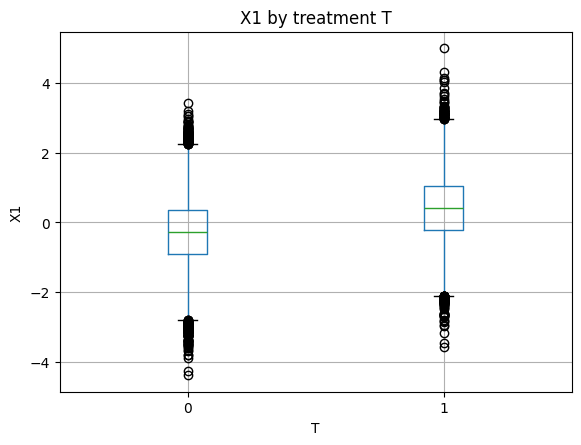

<Figure size 640x480 with 0 Axes>

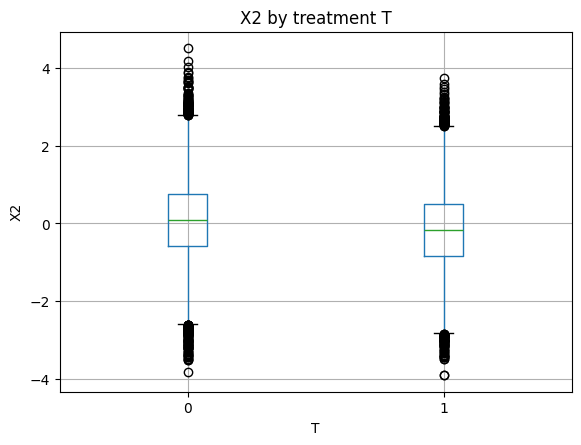

<Figure size 640x480 with 0 Axes>

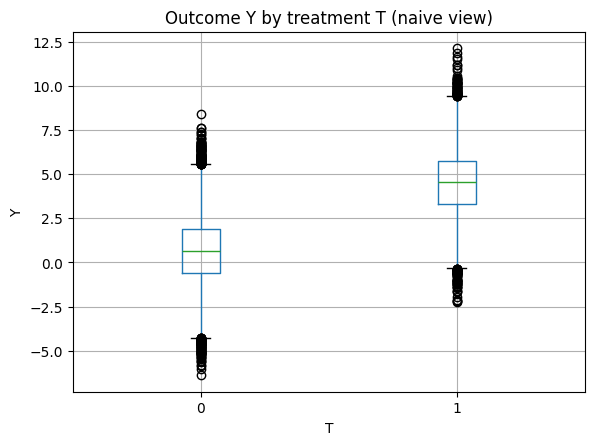

In [73]:
import matplotlib.pyplot as plt

# Boxplots of X1 by treatment group
plt.figure()
df.boxplot(column="X1", by="T")
plt.title("X1 by treatment T")
plt.suptitle("")
plt.xlabel("T")
plt.ylabel("X1")

# Boxplots of X2 by treatment group
plt.figure()
df.boxplot(column="X2", by="T")
plt.title("X2 by treatment T")
plt.suptitle("")
plt.xlabel("T")
plt.ylabel("X2")

# Y vs T (before adjustment)
plt.figure()
df.boxplot(column="Y", by="T")
plt.title("Outcome Y by treatment T (naive view)")
plt.suptitle("")
plt.xlabel("T")
plt.ylabel("Y")

plt.show()
